In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import datetime

In [2]:
# 再現性のためランダムシード固定
np.random.seed(seed=0)
tensorflow.random.set_seed(seed=0)

In [3]:
base_dir = "./pressure/"

df_files = []

for csv in os.listdir(base_dir):
    df_files.append(pd.read_csv(os.path.join(base_dir, csv), encoding="shift-jis", header=2))


In [4]:
def df_extract(df):
    return df.iloc[1:, :2]

for i in range(len(df_files)):
    df_files[i] = df_extract(df_files[i])


In [5]:
for i in range(len(df_files)):
    print(df_files[i].isnull().sum())

年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日            0
平均現地気圧(hPa)    0
dtype: int64
年月日          

In [6]:
for df in df_files[1:]:
    df_files[0] = pd.merge(df_files[0], df, on="年月日")


In [7]:
df_temperature = df_files[0]
df_tmp = df_temperature['平均気温(℃)']
df_temperature.drop('平均気温(℃)', axis=1, inplace=True)
df_temperature = pd.concat([df_temperature, df_tmp], axis=1)
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10228 entries, 0 to 10227
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   年月日            10228 non-null  object 
 1   平均現地気圧(hPa)_x  10228 non-null  float64
 2   平均現地気圧(hPa)_y  10228 non-null  float64
 3   平均現地気圧(hPa)_x  10228 non-null  float64
 4   平均現地気圧(hPa)_y  10228 non-null  float64
 5   平均現地気圧(hPa)_x  10228 non-null  float64
 6   平均現地気圧(hPa)_y  10228 non-null  float64
 7   平均現地気圧(hPa)_x  10228 non-null  float64
 8   平均現地気圧(hPa)_y  10228 non-null  float64
 9   平均現地気圧(hPa)_x  10228 non-null  float64
 10  平均現地気圧(hPa)_y  10228 non-null  float64
 11  平均現地気圧(hPa)_x  10228 non-null  float64
 12  平均現地気圧(hPa)_y  10228 non-null  float64
 13  平均現地気圧(hPa)_x  10228 non-null  float64
 14  平均現地気圧(hPa)_y  10228 non-null  float64
 15  平均現地気圧(hPa)_x  10228 non-null  float64
 16  平均現地気圧(hPa)_y  10228 non-null  float64
 17  平均現地気圧(hPa)_x  10228 non-null  float64
 18  平均現地気圧

In [8]:
df_temperature

,年月日,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,...,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa)_x,平均現地気圧(hPa)_y,平均現地気圧(hPa),平均気温(℃)
0,1992/6/18,1001.3,1006.8,1010.5,1006.6,1004.5,1006.2,1008.2,1002.8,1005.8,...,993.3,1007.7,1005.0,1007.2,1005.7,1006.2,992.4,1007.0,976.7,17.4
1,1992/6/19,1006.6,1010.7,1013.6,1012.0,1008.9,1012.1,1012.3,1006.7,1011.2,...,997.9,1012.5,1009.9,1012.7,1011.8,1011.0,995.9,1011.3,981.0,18.8
2,1992/6/20,1005.2,1011.3,1014.1,1009.9,1008.1,1011.4,1012.3,1006.6,1010.0,...,997.0,1011.7,1008.3,1012.3,1011.5,1009.8,996.3,1011.1,980.5,17.7
3,1992/6/21,1001.1,1006.5,1011.3,1003.0,1006.0,1008.5,1009.2,999.4,1006.1,...,988.9,1009.5,1001.3,1009.9,1007.9,1008.0,990.3,1008.3,974.5,18.1
4,1992/6/22,1001.6,1006.6,1010.1,1006.7,1003.9,1007.1,1005.4,1001.4,1006.2,...,992.4,1008.0,1004.5,1006.9,1007.3,1006.5,991.2,1005.5,976.1,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10223,2020/6/14,999.3,1000.6,1002.7,1004.7,1003.0,1003.0,1005.2,996.4,1003.9,...,989.2,1005.6,1002.4,1002.5,1002.3,1004.8,986.0,1004.4,973.0,22.4
10224,2020/6/15,996.9,998.3,999.4,999.8,1002.5,1002.9,1005.3,992.2,1001.4,...,984.5,1004.0,997.5,1002.9,1001.5,1002.8,983.1,1004.2,969.0,26.5
10225,2020/6/16,996.7,998.8,999.4,1000.3,1001.5,1003.1,1004.5,993.1,1001.4,...,984.8,1003.7,997.9,1003.7,1002.0,1002.4,983.9,1003.3,969.2,25.4
10226,2020/6/17,999.6,1005.4,1006.7,1006.0,1002.1,1005.0,1004.2,998.5,1004.1,...,990.5,1005.9,1003.7,1004.9,1005.5,1004.3,989.2,1003.8,973.6,24.1


In [9]:
df_temperature.index = pd.to_datetime(df_temperature['年月日'])
df_temperature.drop('年月日', axis=1, inplace=True)

In [10]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10228 entries, 1992-06-18 to 2020-06-18
Data columns (total 48 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   平均現地気圧(hPa)_x  10228 non-null  float64
 1   平均現地気圧(hPa)_y  10228 non-null  float64
 2   平均現地気圧(hPa)_x  10228 non-null  float64
 3   平均現地気圧(hPa)_y  10228 non-null  float64
 4   平均現地気圧(hPa)_x  10228 non-null  float64
 5   平均現地気圧(hPa)_y  10228 non-null  float64
 6   平均現地気圧(hPa)_x  10228 non-null  float64
 7   平均現地気圧(hPa)_y  10228 non-null  float64
 8   平均現地気圧(hPa)_x  10228 non-null  float64
 9   平均現地気圧(hPa)_y  10228 non-null  float64
 10  平均現地気圧(hPa)_x  10228 non-null  float64
 11  平均現地気圧(hPa)_y  10228 non-null  float64
 12  平均現地気圧(hPa)_x  10228 non-null  float64
 13  平均現地気圧(hPa)_y  10228 non-null  float64
 14  平均現地気圧(hPa)_x  10228 non-null  float64
 15  平均現地気圧(hPa)_y  10228 non-null  float64
 16  平均現地気圧(hPa)_x  10228 non-null  float64
 17  平均現地気圧(hPa)_y  10228 non-null  fl

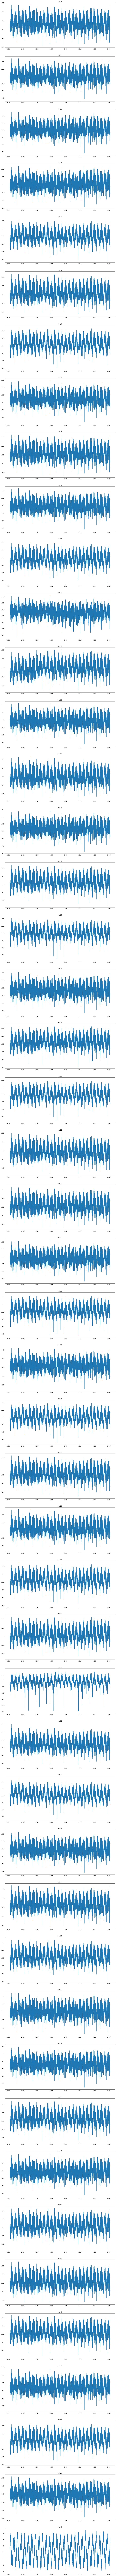

'\n 0   平均現地気圧(hPa)_x  10228 non-null  float64\n 1   平均現地気圧(hPa)_y  10228 non-null  float64\n 2   平均現地気圧(hPa)_x  10228 non-null  float64\n 3   平均現地気圧(hPa)_y  10228 non-null  float64\n 4   平均現地気圧(hPa)_x  10228 non-null  float64\n 5   平均現地気圧(hPa)_y  10228 non-null  float64\n 6   平均現地気圧(hPa)_x  10228 non-null  float64\n 7   平均現地気圧(hPa)_y  10228 non-null  float64\n 8   平均現地気圧(hPa)_x  10228 non-null  float64\n 9   平均現地気圧(hPa)_y  10228 non-null  float64\n 10  平均現地気圧(hPa)_x  10228 non-null  float64\n 11  平均現地気圧(hPa)_y  10228 non-null  float64\n 12  平均現地気圧(hPa)_x  10228 non-null  float64\n 13  平均現地気圧(hPa)_y  10228 non-null  float64\n 14  平均現地気圧(hPa)_x  10228 non-null  float64\n 15  平均現地気圧(hPa)_y  10228 non-null  float64\n 16  平均現地気圧(hPa)_x  10228 non-null  float64\n 17  平均現地気圧(hPa)_y  10228 non-null  float64\n 18  平均現地気圧(hPa)_x  10228 non-null  float64\n 19  平均現地気圧(hPa)_y  10228 non-null  float64\n 20  平均現地気圧(hPa)_x  10228 non-null  float64\n 21  平均現地気圧(hPa)_y  10228 non-null  float64\n 22  平均

In [11]:
# グラフ化
fig, axes = plt.subplots(len(df_temperature.columns), 1, figsize=(16, 8*len(df_temperature.columns)))
axes.flatten()

for i in range(len(df_temperature.columns)):
    axes[i].plot(df_temperature.index, df_temperature.values[:, i])
    axes[i].set_title(f"No.{i}")
plt.show()

"""
 0   平均現地気圧(hPa)_x  10228 non-null  float64
 1   平均現地気圧(hPa)_y  10228 non-null  float64
 2   平均現地気圧(hPa)_x  10228 non-null  float64
 3   平均現地気圧(hPa)_y  10228 non-null  float64
 4   平均現地気圧(hPa)_x  10228 non-null  float64
 5   平均現地気圧(hPa)_y  10228 non-null  float64
 6   平均現地気圧(hPa)_x  10228 non-null  float64
 7   平均現地気圧(hPa)_y  10228 non-null  float64
 8   平均現地気圧(hPa)_x  10228 non-null  float64
 9   平均現地気圧(hPa)_y  10228 non-null  float64
 10  平均現地気圧(hPa)_x  10228 non-null  float64
 11  平均現地気圧(hPa)_y  10228 non-null  float64
 12  平均現地気圧(hPa)_x  10228 non-null  float64
 13  平均現地気圧(hPa)_y  10228 non-null  float64
 14  平均現地気圧(hPa)_x  10228 non-null  float64
 15  平均現地気圧(hPa)_y  10228 non-null  float64
 16  平均現地気圧(hPa)_x  10228 non-null  float64
 17  平均現地気圧(hPa)_y  10228 non-null  float64
 18  平均現地気圧(hPa)_x  10228 non-null  float64
 19  平均現地気圧(hPa)_y  10228 non-null  float64
 20  平均現地気圧(hPa)_x  10228 non-null  float64
 21  平均現地気圧(hPa)_y  10228 non-null  float64
 22  平均現地気圧(hPa)_x  10228 non-null  float64
 23  平均現地気圧(hPa)_y  10228 non-null  float64
 24  平均現地気圧(hPa)_x  10228 non-null  float64
 25  平均現地気圧(hPa)_y  10228 non-null  float64
 26  平均現地気圧(hPa)_x  10228 non-null  float64
 27  平均現地気圧(hPa)_y  10228 non-null  float64
 28  平均現地気圧(hPa)_x  10228 non-null  float64
 29  平均現地気圧(hPa)_y  10228 non-null  float64
 30  平均現地気圧(hPa)_x  10228 non-null  float64
 31  平均現地気圧(hPa)_y  10228 non-null  float64
 32  平均現地気圧(hPa)_x  10228 non-null  float64
 33  平均現地気圧(hPa)_y  10228 non-null  float64
 34  平均現地気圧(hPa)_x  10228 non-null  float64
 35  平均現地気圧(hPa)_y  10228 non-null  float64
 36  平均現地気圧(hPa)_x  10228 non-null  float64
 37  平均現地気圧(hPa)_y  10228 non-null  float64
 38  平均現地気圧(hPa)_x  10228 non-null  float64
 39  平均現地気圧(hPa)_y  10228 non-null  float64
 40  平均現地気圧(hPa)_x  10228 non-null  float64
 41  平均現地気圧(hPa)_y  10228 non-null  float64
 42  平均現地気圧(hPa)_x  10228 non-null  float64
 43  平均現地気圧(hPa)_y  10228 non-null  float64
 44  平均現地気圧(hPa)_x  10228 non-null  float64
 45  平均現地気圧(hPa)_y  10228 non-null  float64
 46  平均現地気圧(hPa)_x  10228 non-null  float64
 47  平均現地気圧(hPa)_y  10228 non-null  float64
 48  平均気温(℃)        10228 non-null  float64
 """

In [12]:
df_temperature.shape

(10228, 48)

In [13]:
def create_dataset(dataset, look_back):
    data_X, data_y = [], []
    for i in range(look_back, len(dataset)):
        data_X.append(dataset[i-look_back:i, :])
        data_y.append(dataset[i, -1])
        
    return np.array(data_X), np.array(data_y)

# データセットをtrainとtestに分割
div_idx_test = len(df_temperature) * 2 // 3
train, test = df_temperature.values[:div_idx_test, :].copy(), df_temperature.values[div_idx_test:, :].copy()

# trainデータセットからvalidデータを分割
div_idx_valid = len(train)*3//4
train, valid = train[:div_idx_valid, :], train[div_idx_valid:, :]

# データをMinMax
scaler_train_temperature = 0
for i in range(len(df_temperature.columns)):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler_train = scaler.fit(np.reshape(train[:, i], (train.shape[0], 1)))
    train[:, i] = scaler_train.transform(np.reshape(train[:, i], (train.shape[0], 1))).flatten()
    valid[:, i] = scaler_train.transform(np.reshape(valid[:, i], (valid.shape[0], 1))).flatten()
    test[:, i] = scaler_train.transform(np.reshape(test[:, i], (test.shape[0], 1))).flatten()
    # temperatureのMin-Max変換だけ予測結果を逆変換する必要があるため保持する
    if i == len(df_temperature.columns)-1:
        scaler_train_temperature = scaler

# 終値をdatasetに変換
look_back = 30
train_X, train_y = create_dataset(train, look_back)
valid_X, valid_y = create_dataset(valid, look_back)
test_X, test_y = create_dataset(test, look_back)

train_X = np.reshape(train_X, (train.shape[0]-look_back, look_back, train.shape[1]))
valid_X = np.reshape(valid_X, (valid.shape[0]-look_back, look_back, valid.shape[1]))
test_X = np.reshape(test_X, (test.shape[0]-look_back, look_back, train.shape[1]))

print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)

(5083, 30, 48) (5083,) (1675, 30, 48) (1675,) (3380, 30, 48) (3380,)


In [14]:
# LSTM
model = Sequential()
model.add(LSTM(80,
               input_shape=(look_back, train.shape[1]),
               recurrent_dropout=0.02))
model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode="min")

model.compile(optimizer='adam', loss='mean_squared_error', lr=1e-3)
model.fit(train_X, train_y,
          epochs=60, 
          batch_size=16, 
          verbose=1, 
          validation_data=[valid_X, valid_y],
          callbacks=[es])


Train on 5083 samples, validate on 1675 samples
Epoch 1/60
5083/5083 [==============================] - 36s 7ms/sample - loss: 0.0136 - val_loss: 0.0072
Epoch 2/60
5083/5083 [==============================] - 23s 4ms/sample - loss: 0.0051 - val_loss: 0.0037
Epoch 3/60
5083/5083 [==============================] - 23s 4ms/sample - loss: 0.0045 - val_loss: 0.0036
Epoch 4/60
5083/5083 [==============================] - 22s 4ms/sample - loss: 0.0044 - val_loss: 0.0032
Epoch 5/60
5083/5083 [==============================] - 23s 5ms/sample - loss: 0.0036 - val_loss: 0.0030
Epoch 6/60
5083/5083 [==============================] - 23s 4ms/sample - loss: 0.0039 - val_loss: 0.0035
Epoch 7/60
5083/5083 [==============================] - 22s 4ms/sample - loss: 0.0035 - val_loss: 0.0028
Epoch 8/60
5083/5083 [==============================] - 23s 4ms/sample - loss: 0.0034 - val_loss: 0.0036
Epoch 9/60
5083/5083 [==============================] - 23s 4ms/sample - loss: 0.0035 - val_loss: 0.0032
Epoch 1

In [15]:
# 予測
train_predict = model.predict(train_X)
valid_predict = model.predict(valid_X)
test_predict = model.predict(test_X)

# MInMax逆変換
train_predict = scaler_train_temperature.inverse_transform(train_predict)
train_y = scaler_train_temperature.inverse_transform([train_y])
valid_predict = scaler_train_temperature.inverse_transform(valid_predict)
valid_y = scaler_train_temperature.inverse_transform([valid_y])
test_predict = scaler_train_temperature.inverse_transform(test_predict)
test_y = scaler_train_temperature.inverse_transform([test_y])

# 精度
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[:, 0]))
print(f"train score: {train_score}")
valid_score = math.sqrt(mean_squared_error(valid_y[0], valid_predict[:, 0]))
print(f"valid_score: {valid_score}")
test_score = math.sqrt(mean_squared_error(test_y[0], test_predict[:, 0]))
print(f"test score: {test_score}")


train score: 1.679934636738508
valid_score: 1.6450466013884204
test score: 1.666360846975873


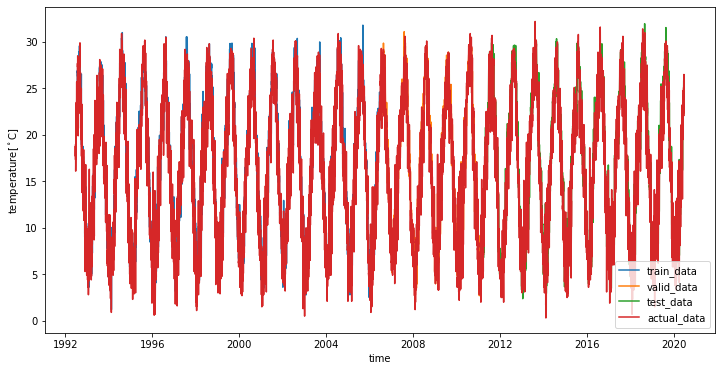

In [16]:
# グラフ化
train_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, -1], (len(df_temperature), 1)))
train_predict_plot[:, :] = np.nan
idx_train_predict = look_back+len(train_predict)
train_predict_plot[look_back:idx_train_predict, :] = train_predict

valid_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, -1], (len(df_temperature), 1)))
valid_predict_plot[:, :] = np.nan
idx_valid_predict = look_back+idx_train_predict + len(valid_predict)
valid_predict_plot[look_back+idx_train_predict:idx_valid_predict, :] = valid_predict

test_predict_plot = np.empty_like(np.reshape(df_temperature.values[:, -1], (len(df_temperature), 1)))
test_predict_plot[:, :] = np.nan
test_predict_plot[look_back+idx_valid_predict:, :] = test_predict
         
actual_plot = df_temperature.values[:, -1]

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(df_temperature.index, train_predict_plot, label='train_data')
ax.plot(df_temperature.index, valid_predict_plot, label='valid_data')
ax.plot(df_temperature.index, test_predict_plot, label='test_data')
ax.plot(df_temperature.index, actual_plot, label='actual_data')
ax.set_ylabel("temperature[$^\circ$C]")
ax.set_xlabel("time")
ax.legend(loc='lower right')
plt.show()
fig.savefig('img.png')
   

In [17]:
# 予測値と実際の値の差分
predict_data = np.full(shape=(len(df_temperature), 1), fill_value=-999)
predict_data[look_back:look_back+len(train_predict), :] = train_predict
predict_data[look_back*2+len(train_predict): look_back*2+len(train_predict)+len(valid_predict), :] = valid_predict
predict_data[look_back*3+len(train_predict)+len(valid_predict):, :] = test_predict

diff = df_temperature.values[:, -1] - predict_data[:, 0]
diff[diff>=900] = 0


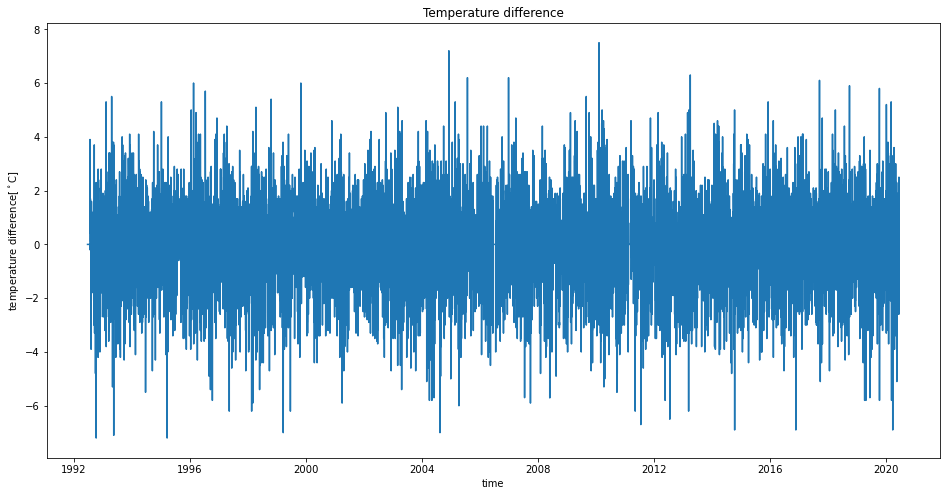

In [18]:
# プロット
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.plot(df_temperature.index, diff)
ax.set_ylabel('temperature difference[$^\circ$C]')
ax.set_xlabel('time')
ax.set_title('Temperature difference')

plt.show()
fig.savefig('diff.png')


In [19]:
# 誤差平均、不偏標準偏差、誤差最大/最小
diff_mean = np.mean(diff)
diff_std = np.std(diff, ddof=1)
diff_max = np.max(abs(diff))
diff_min = np.min(abs(diff))
print(f"mean: {diff_mean}")
print(f"std: {diff_std}")
print(f"max: {diff_max}")
print(f"min: {diff_min}")

mean: 0.004184591317950733
std: 1.6144242289536899
max: 7.5
min: 0.0


■予測結果からずれの大きい日を確認し、誤差要因を考察する

In [20]:
def create_large_diff(lim_num=7):
    acutual_large_diff = df_temperature.values[np.where(abs(diff)>=lim_num)]
    predict_large_diff = predict_data[np.where(abs(diff)>=lim_num)]
    large_diff_abs = abs(diff[np.where(abs(diff)>=lim_num)])
    day = df_temperature.index.values[np.where(abs(diff)>=lim_num)]
                                           
    df_large_diff = pd.DataFrame({'day': day,
                                  'acutual': acutual_large_diff[:, -1],
                                  'predict': predict_large_diff[:, -1],
                                  'diff_abs': large_diff_abs})

    df_large_diff = df_large_diff.sort_values('diff_abs', ascending=False).reset_index(drop=True)

    season = []
    month = []

    for i in range(len(df_large_diff)):
        tmp_month = df_large_diff.iloc[i, 0].month
        month.append(tmp_month)
        if tmp_month >= 3 and tmp_month <= 5:
            season.append("spring")
        elif tmp_month >= 6 and tmp_month <= 8:
            season.append("summer")
        elif tmp_month >= 9 and tmp_month <= 11:
            season.append('autumn')
        else:
            season.append('winter')
        
    df_large_diff['season'] = season
    df_large_diff['month'] = month
    
    return df_large_diff 

# 誤差が7度以上の日をまとめる
df_large_diff = create_large_diff(lim_num=7)


In [21]:
df_large_diff

,day,acutual,predict,diff_abs,season,month
0,2010-02-09,15.5,8,7.5,winter,2
1,1995-03-18,6.8,14,7.2,spring,3
2,1992-10-05,13.8,21,7.2,autumn,10
3,2004-12-05,18.2,11,7.2,winter,12
4,1993-05-14,13.9,21,7.1,spring,5
5,1999-03-20,6.0,13,7.0,spring,3
6,2004-08-15,21.0,28,7.0,summer,8


In [22]:
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 10       1        1        1         1
spring 3        2        2        2         2
       5        1        1        1         1
summer 8        1        1        1         1
winter 2        1        1        1         1
       12       1        1        1         1

In [23]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 3
summer: 1
autumn: 1
winter: 2


In [24]:
(len(df_large_diff[df_large_diff['season']=="spring"]) + len(df_large_diff[df_large_diff['season']=="winter"]))/len(df_large_diff)

0.7142857142857143

誤差が7度以上だった季節のうち、春と冬が71%を占めている。

In [25]:
# 誤差が5度以上の日をまとめる
df_large_diff = create_large_diff(lim_num=5)
df_large_diff.groupby(['season', 'month']).count()

day  acutual  predict  diff_abs
season month                                 
autumn 9        6        6        6         6
       10       9        9        9         9
       11       1        1        1         1
spring 3       13       13       13        13
       4       12       12       12        12
       5        9        9        9         9
summer 6        4        4        4         4
       7        5        5        5         5
       8        1        1        1         1
winter 1        3        3        3         3
       2        5        5        5         5
       12       4        4        4         4

In [26]:
(len(df_large_diff[df_large_diff['month']==2]) +
 len(df_large_diff[df_large_diff['month']==3]) +
 len(df_large_diff[df_large_diff['month']==4]) +
 len(df_large_diff[df_large_diff['month']==5]))/len(df_large_diff)

0.5416666666666666

誤差が5度以上だった月のうち、2～5月までが54%を占めている。

In [27]:
for s in ['spring', 'summer', 'autumn', 'winter']:
    print(f"{s}: {len(df_large_diff[df_large_diff['season']==s])}")


spring: 34
summer: 10
autumn: 16
winter: 12


In [28]:
(len(df_large_diff[df_large_diff['season']=="spring"]))/len(df_large_diff)

0.4722222222222222

誤差が5度以上だった季節のうち、春が47%を占めている。

誤差の大きい日の前後の温度を確認する

In [29]:
def plot_day_front_back(df, day, save_fig_name, len=7):
    t = day-datetime.timedelta(days=len)
    actual_temperature_list = []
    days_list = []
    pred_temperature_list = []
    for i in range(len*2+1):
        actual_temperature_list.append(df.loc[t, df.columns[-1]])
        days_list.append(t)
        idx = (t-df.index[0]).days
        
        if idx < 0 or idx >= df.shape[0]:
            continue
        if idx >= look_back and idx < idx_train_predict:
            pred_temperature_list.append(train_predict_plot[idx, 0])
        elif idx >= look_back+idx_train_predict and idx < idx_valid_predict:
            pred_temperature_list.append(valid_predict_plot[idx, 0])
        elif idx >= look_back+idx_valid_predict:
            pred_temperature_list.append(test_predict_plot[idx, 0])
        else:
            pred_temperature.append(0)

        t += datetime.timedelta(days=1)    

    fig, ax= plt.subplots(1, 1, figsize=(16,8))
    ax.plot(days_list, actual_temperature_list, label="actual", color="blue")
    ax.plot(days_list, pred_temperature_list, label="predict", color="orange")
    ax.set_xlabel('time')
    ax.set_ylabel('temperature[$^\circ$C]')
    ax.axvline(x=day, color="red") # 基準線用
    ax.legend()
    ax.grid()
    plt.show()
    fig.savefig(save_fig_name)


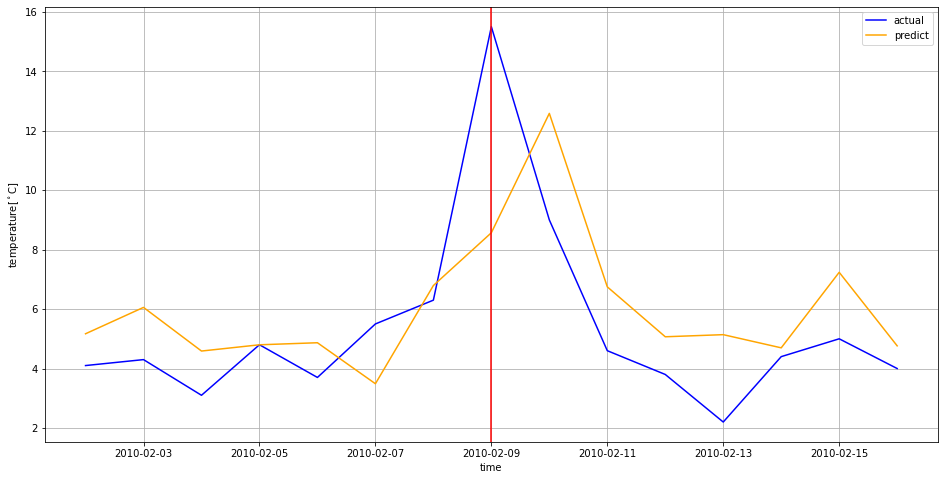

In [30]:
# 誤差1位
plot_day_front_back(df_temperature, df_large_diff.loc[0, 'day'], 'error1.png')


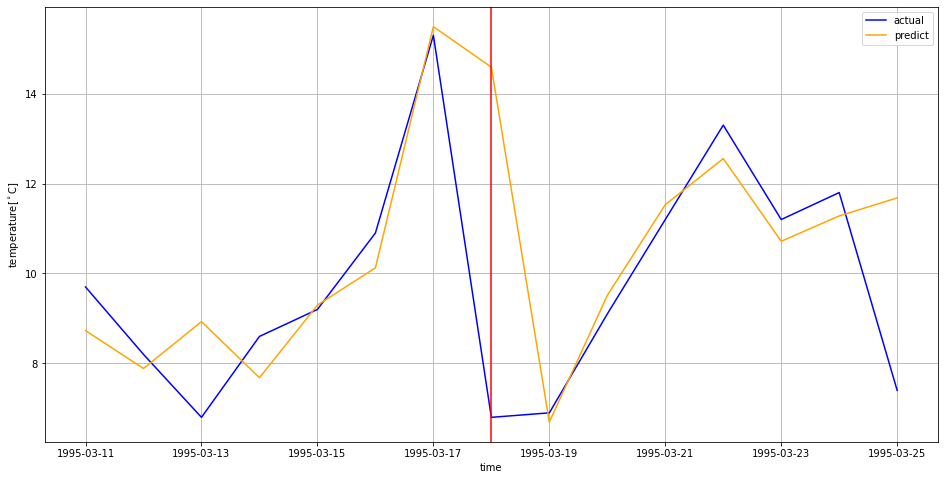

In [31]:
# 誤差2位
plot_day_front_back(df_temperature, df_large_diff.loc[1, 'day'], 'error2.png')

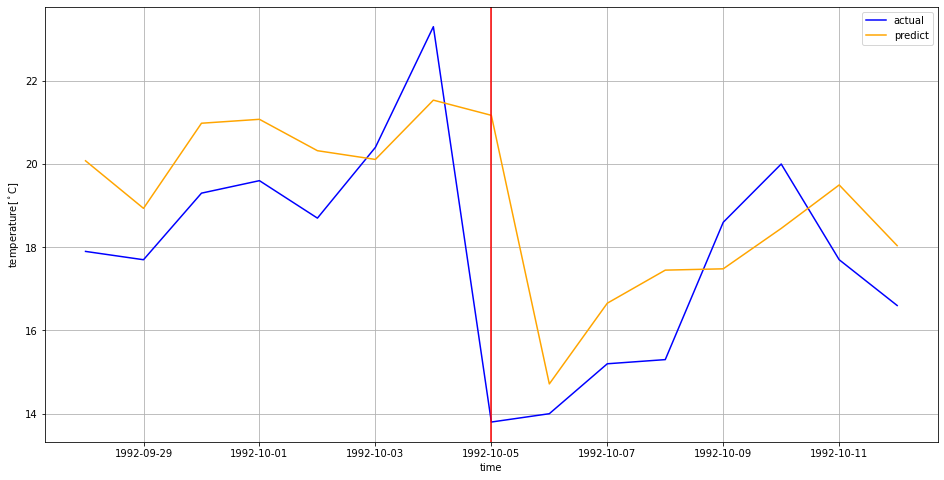

In [32]:
# 誤差3位
plot_day_front_back(df_temperature, df_large_diff.loc[2, 'day'], 'error3.png')

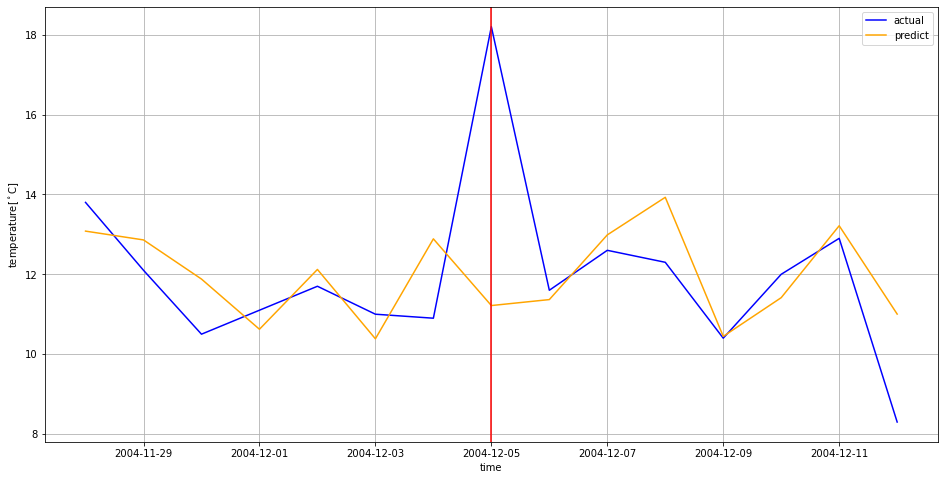

In [33]:
# 誤差4位
plot_day_front_back(df_temperature, df_large_diff.loc[3, 'day'], 'error4.png')

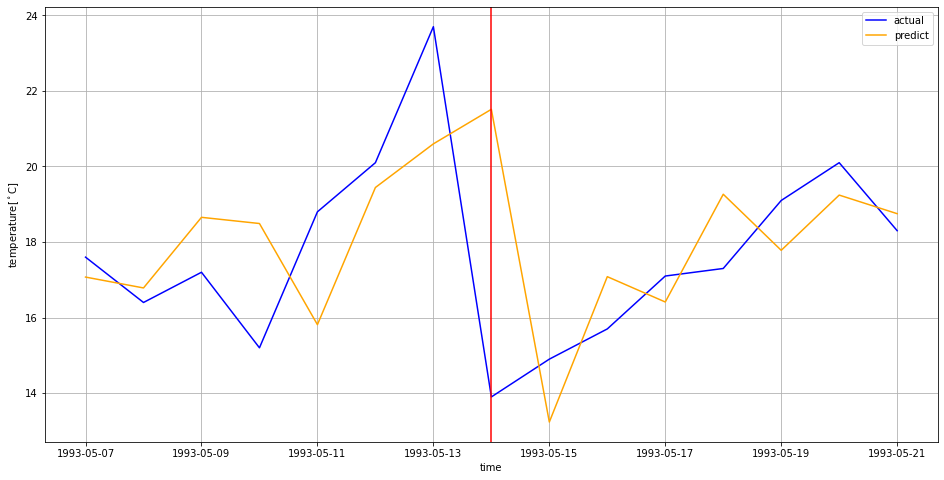

In [34]:
# 誤差5位
plot_day_front_back(df_temperature, df_large_diff.loc[4, 'day'], 'error5.png')

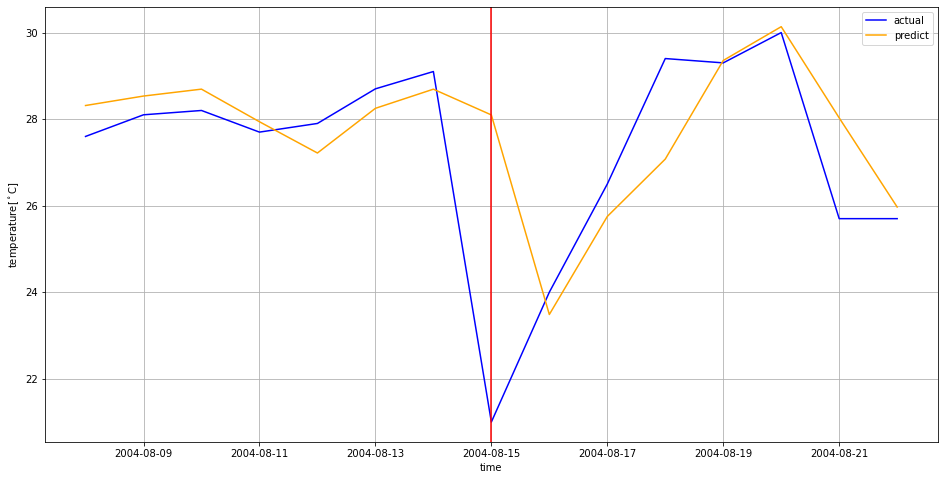

In [35]:
# 誤差6位
plot_day_front_back(df_temperature, df_large_diff.loc[5, 'day'], 'error6.png')

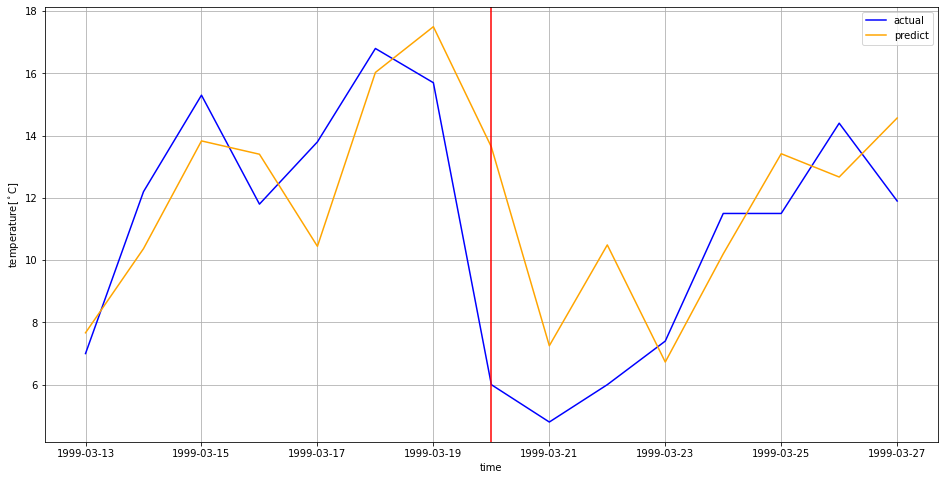

In [36]:
# 誤差7位
plot_day_front_back(df_temperature, df_large_diff.loc[6, 'day'], 'error7.png')

気圧データを追加することで急激な温度変化にやや追随できていることがわかる。<br>